Welcome to the Scratch Detection Project. In the semiconductor manufacturing process, detecting defects like scratches on wafers is crucial for ensuring high-quality microelectronic devices. This project focuses on developing a machine learning model capable of identifying and classifying scratches in wafer maps. By analyzing individual dies on the wafer, the goal is to accurately predict which dies are affected by scratches, improving quality control and automating a traditionally manual process. In this notebook, we explore how machine learning techniques can enhance defect detection, contributing to more efficient and reliable semiconductor manufacturing.

# Start work

In [15]:
import pandas as pd
import zipfile
from datetime import datetime

### Load Data

In [16]:
#load zip file
zf = zipfile.ZipFile('data.zip') 

In [17]:
#load train data
df_wafers = pd.read_csv(zf.open('wafers_train.csv'))
df_wafers.head()

,WaferName,DieX,DieY,IsGoodDie,IsScratchDie
0,8PFrAN,0,27,True,False
1,8PFrAN,0,28,True,False
2,8PFrAN,0,29,True,False
3,8PFrAN,0,30,True,False
4,8PFrAN,0,31,True,False


In [32]:
#load test data
df_wafers_test = pd.read_csv(zf.open('wafers_test.csv'))
df_wafers_test.head()



,WaferName,DieX,DieY,IsGoodDie
0,mZa9ls,0,23,True
1,mZa9ls,0,24,True
2,mZa9ls,0,25,True
3,mZa9ls,0,26,True
4,mZa9ls,0,27,True


You can draw the wafers map to see how the wafers look like in the data. 

Using the following helper function you can draw the wafer maps with or without labels:

In [22]:
def plot_wafer_maps(wafer_df_list, figsize, labels = True):
    """
    plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height 
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')
    
    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17/(wafer_size)
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum()>0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum()/(wafer_df['IsGoodDie']).count(), 2)) 
        
        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color = 'green', marker='s', s = s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color = 'red', marker='s', s = s)
        
        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color = 'blue', marker='s', s = s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color = 'yellow', marker='s', s = s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 
    
    import numpy as np
    import matplotlib.pyplot as plt
    
    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize*2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize*len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

Select the amount of samples you want to display:

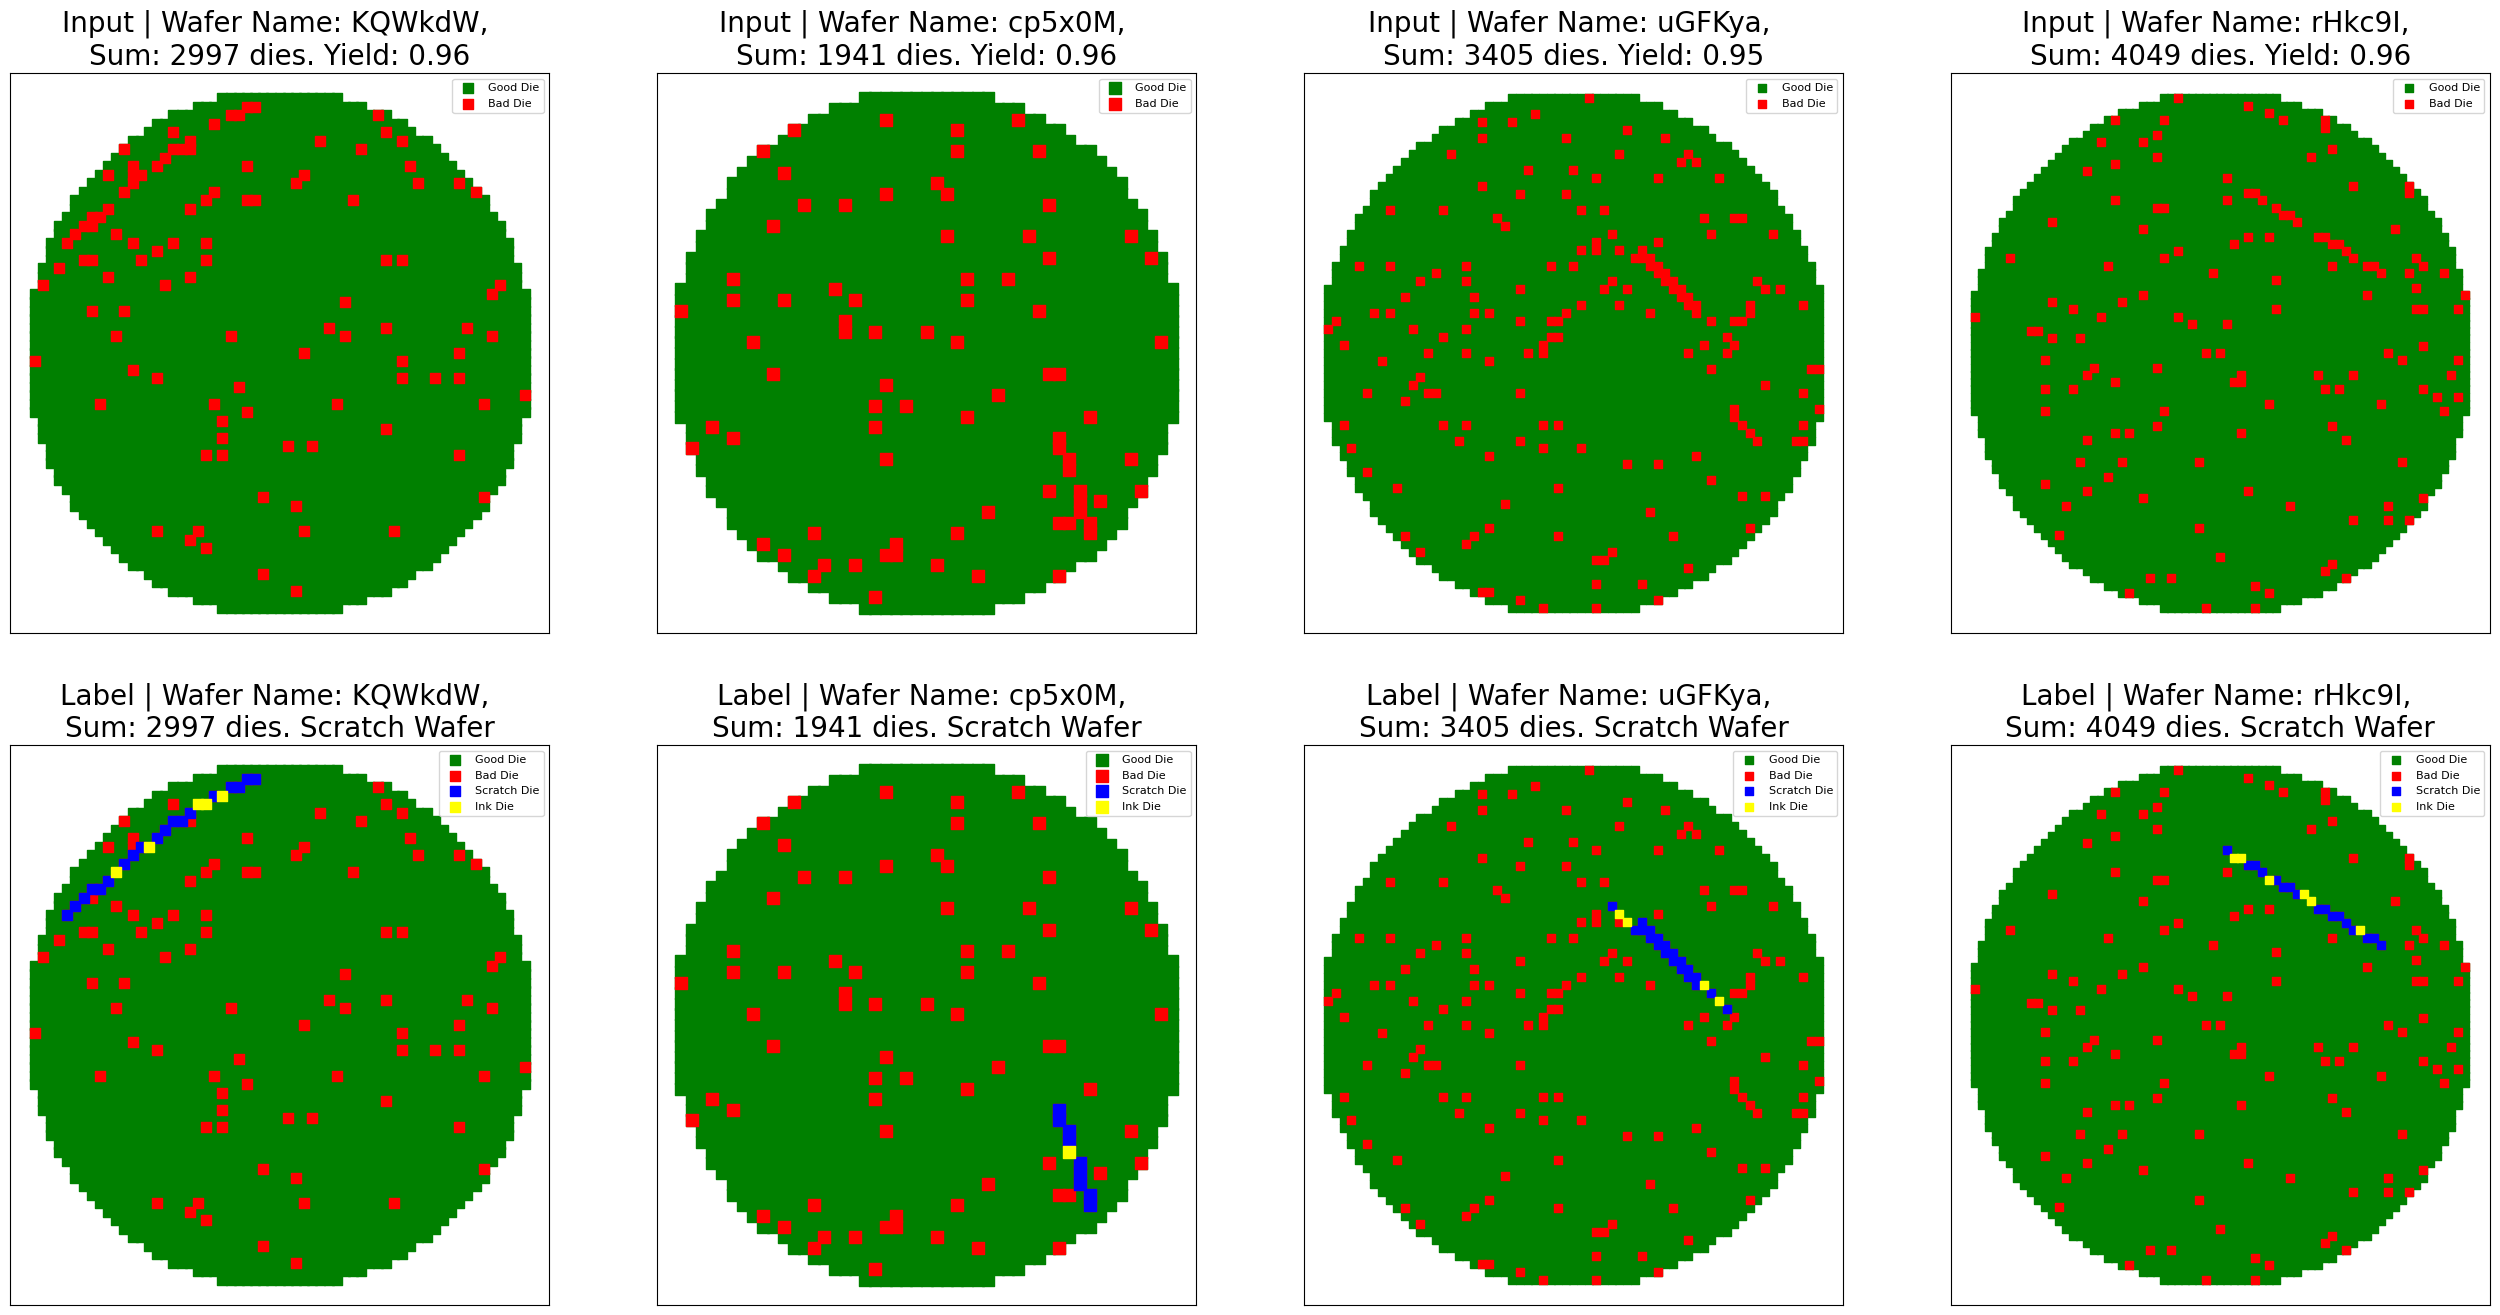

In [34]:
n_samples = 4
list_sample_train = [df_wafers.groupby('WaferName').get_group(group) for group in df_wafers['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_train, figsize = 8, labels = True)

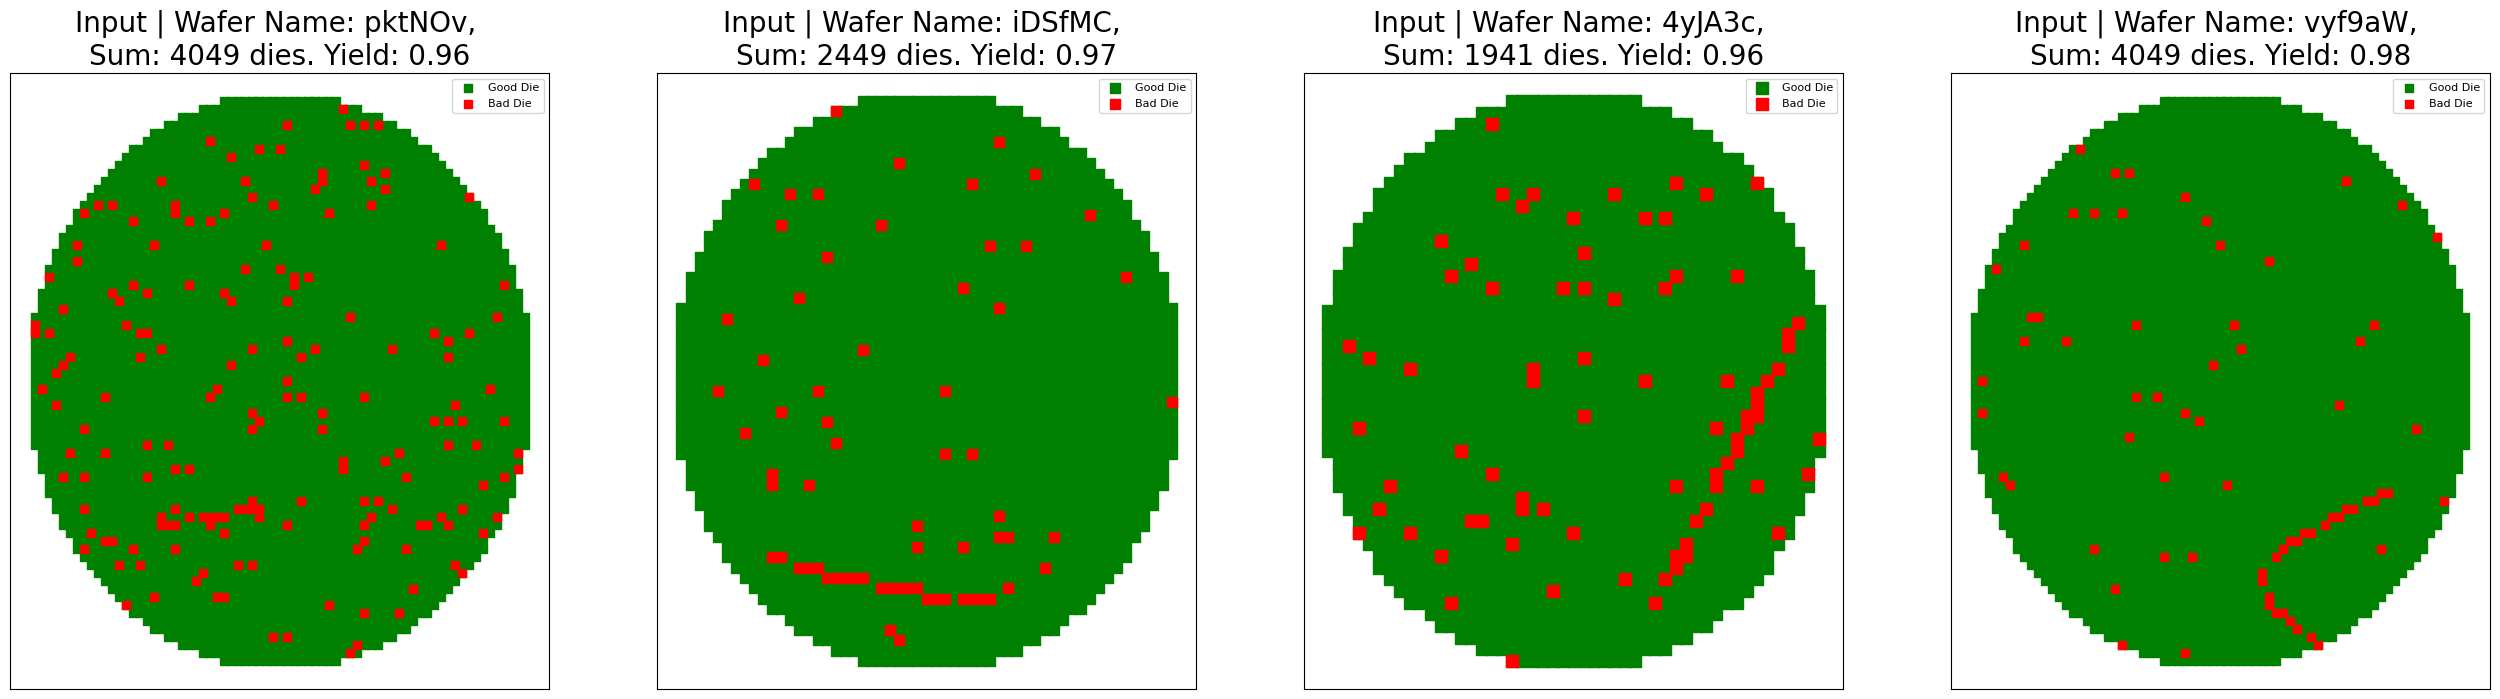

In [35]:
list_sample_test = [df_wafers_test.groupby('WaferName').get_group(group) for group in df_wafers_test['WaferName'].value_counts().sample(n_samples, random_state=20).index]
plot_wafer_maps(list_sample_test, figsize = 8, labels = False)

# Build your solution

In [18]:
list_train = [group for _, group in df_wafers.groupby('WaferName')]



**cheak Types\sizes of warfer counter:**

In [19]:
import pandas as pd

# קריאת הנתונים מתוך הקובץ (בהנחה שכבר טענת את zf ואת הקובץ wafers_train.csv)
df_wafers_train = pd.read_csv(zf.open('wafers_train.csv'))

# מציאת שמות וופרים ייחודיים
unique_wafer_names = df_wafers_train['WaferName'].unique()
print(f"Total unique wafers: {len(unique_wafer_names)}")

# ספירת מספר רשומות לכל Wafer
wafer_sizes = df_wafers_train['WaferName'].value_counts()

# ספירת כמה וופרים יש מכל גודל (כמה פעמים מופיעה כל כמות dies)
wafer_size_distribution = wafer_sizes.value_counts().sort_index()

print("\nNumber of wafers by size (number of dies per wafer):")
print(wafer_size_distribution)


Total unique wafers: 4200

Number of wafers by size (number of dies per wafer):
count
1005    600
1513    600
1941    600
2449    600
2997    600
3405    600
4049    600
Name: count, dtype: int64


**cheack if the warfer is sorted**

In [31]:
import pandas as pd

# קריאת הנתונים מתוך הקובץ
df_wafers_train = pd.read_csv(zf.open('wafers_train.csv'))

# מיון לפי כמות הרשומות בכל WaferName
wafer_sizes = df_wafers_train['WaferName'].value_counts().sort_values(ascending=False)

# יצירת DataFrame חדש עם כל WaferName והאם הוא ממויין לפי הגודל
df_sorted = wafer_sizes.reset_index()
df_sorted.columns = ['WaferName', 'Count']
df_sorted['IS_SORTED'] = df_sorted['Count'].is_monotonic_decreasing

# הצגת התוצאה
print(df_sorted)


     WaferName  Count  IS_SORTED
0       8PFrAN   4049       True
1       JfCRkD   4049       True
2       16kAd3   4049       True
3       u6pARZ   4049       True
4       Eg6Vao   4049       True
...        ...    ...        ...
4195    fCshGs   1005       True
4196    t1qmjt   1005       True
4197    Sjycmh   1005       True
4198    dG3khV   1005       True
4199    MaO0Yl   1005       True

[4200 rows x 3 columns]


In [20]:
# קיבוץ לפי WaferName וחישוב אחוז ה־False ב-IsGoodDie לכל דיסק
wafer_defect_rates = df_wafers_train.groupby('WaferName').apply(
    lambda g: pd.Series({
        'WaferSize': len(g),
        'DefectRate': (g['IsGoodDie'] == False).sum() / len(g)
    })
).reset_index()

# קיבוץ לפי גודל דיסק (מספר dies) וחישוב ממוצע אחוז הפגמים לכל גודל
avg_defect_by_size = wafer_defect_rates.groupby('WaferSize')['DefectRate'].mean().reset_index()

# הדפסה מסודרת של התוצאות
print("\nAverage defect rate by wafer size:")
print(avg_defect_by_size)



Average defect rate by wafer size:
   WaferSize  DefectRate
0     1005.0    0.041189
1     1513.0    0.037805
2     1941.0    0.038410
3     2449.0    0.036768
4     2997.0    0.035885
5     3405.0    0.035086
6     4049.0    0.034905


C:\Users\olegl\AppData\Local\Temp\ipykernel_14732\130572745.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  wafer_defect_rates = df_wafers_train.groupby('WaferName').apply(


**Grouping by size 70 woofers of each size**

In [73]:
import pandas as pd

# קריאת הנתונים מתוך הקובץ
df_wafers_train = pd.read_csv(zf.open('wafers_train.csv'))

# חישוב גודל כל WaferName (כמה רשומות יש לו)
wafer_counts = df_wafers_train['WaferName'].value_counts()

# יצירת DataFrame עם WaferName ו-Size
df_counts = wafer_counts.reset_index()
df_counts.columns = ['WaferName', 'Size']

# מיון לפי Size ואז לפי סדר הופעה (WaferName)
df_counts_sorted = df_counts.sort_values(['Size', 'WaferName'])

# קיבוץ לפי גודל ולקיחת 70 וופרים ראשונים מכל גודל
sampled_wafers = df_counts_sorted.groupby('Size').head(70).reset_index(drop=True)

# הדפסת התוצאה
print(sampled_wafers)



    WaferName  Size
0      01hHtd  1005
1      06yPzs  1005
2      0CUjW7  1005
3      0GpSh2  1005
4      0KW3Y7  1005
..        ...   ...
485    6J1tzd  4049
486    6KmrMp  4049
487    6LQeuS  4049
488    6OEaj6  4049
489    6Sue1W  4049

[490 rows x 2 columns]


**generates geometric features for each wafer based on the proximity of "good" and "bad" dies.**

Features it creates:
BadNeighbors_ofGood
Number of "bad" neighbors (IsGoodDie == False) within a distance of 1.5 around good dies.

BadNeighbors_ofBad
Same as above, but around bad dies.

SecondLayerBadNeighbors_ofGood
Number of bad dies in the second layer (neighbors of neighbors) around good dies.

SecondLayerBadNeighbors_ofBad
Same as above, for bad dies.

DistanceToBadCluster
Distance from each die to the nearest bad die.

In [23]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np

def create_features(wafer_list, limit_to_first_n=None):
    feature_list = []

    if limit_to_first_n is not None:
        print(f"Filtering to first {limit_to_first_n} unique wafers...")
        wafer_names = []
        filtered_wafer_list = []
        for df in wafer_list:
            wafer_name = df['WaferName'].iloc[0]
            if wafer_name not in wafer_names:
                wafer_names.append(wafer_name)
            if wafer_name in wafer_names[:limit_to_first_n]:
                filtered_wafer_list.append(df)
        wafer_list = filtered_wafer_list
        print(f"Filtered wafer list to {len(wafer_list)} wafers.")

    for i, df in enumerate(wafer_list):
        print(f"\nProcessing wafer {i + 1}/{len(wafer_list)}")
        df = df.copy().reset_index(drop=True)

        if 'IsGoodDie' not in df.columns:
            df['IsGoodDie'] = df['IsGoodDie'].fillna(False)

        tree = KDTree(df[['DieX', 'DieY']].values)

        def filter_valid_indices(indices, current_idx):
            return indices[(indices != current_idx) & (indices < len(df))]

        def count_bad_neighbors(index):
            distances, indices = tree.query(df.iloc[index][['DieX', 'DieY']], k=10, distance_upper_bound=1.5)
            neighbor_indices = filter_valid_indices(indices, index)
            return (df.iloc[neighbor_indices]['IsGoodDie'] == False).sum()

        print("Calculating BadNeighbors...")
        bad_neighbors = df.index.to_series().apply(count_bad_neighbors)
        df['BadNeighbors_ofGood'] = np.where(df['IsGoodDie'], bad_neighbors, np.nan)
        df['BadNeighbors_ofBad'] = np.where(~df['IsGoodDie'], bad_neighbors, np.nan)

        def second_layer_bad(index):
            distances, indices = tree.query(df.iloc[index][['DieX', 'DieY']], k=15, distance_upper_bound=4.0)
            neighbor_indices = filter_valid_indices(indices, index)
            second_layer = []
            for neighbor in neighbor_indices:
                if neighbor >= len(df):
                    continue
                d2, i2 = tree.query(df.iloc[neighbor][['DieX', 'DieY']], k=5, distance_upper_bound=1.5)
                valid_second = i2[(i2 != neighbor) & (i2 < len(df))]
                second_layer += list(valid_second)
            second_layer = list(set(second_layer))
            if not second_layer:
                return 0
            return (df.iloc[second_layer]['IsGoodDie'] == False).sum()

        print("Calculating SecondLayerBadNeighbors...")
        second_layer = df.index.to_series().apply(second_layer_bad)
        df['SecondLayerBadNeighbors_ofGood'] = np.where(df['IsGoodDie'], second_layer, np.nan)
        df['SecondLayerBadNeighbors_ofBad'] = np.where(~df['IsGoodDie'], second_layer, np.nan)

        def nearest_bad_distance(index):
            bad_dies = df[df['IsGoodDie'] == False]
            if bad_dies.empty:
                return 10
            bad_tree = KDTree(bad_dies[['DieX', 'DieY']].values)
            distance, _ = bad_tree.query(df.iloc[index][['DieX', 'DieY']])
            return distance

        print("Calculating DistanceToBadCluster...")
        df['DistanceToBadCluster'] = df.index.to_series().apply(nearest_bad_distance)

        feature_list.append(df)
        print(f"Finished processing wafer {i + 1}.\n")

    return feature_list




**Call create_features function to create table with the new features and save it to CSV**

In [74]:
import pandas as pd
from scipy.spatial import KDTree
import numpy as np

# ------------------------------------------------------------
# סינון list_train לפי sampled_wafers

# נניח שכאן כבר טענת את sampled_wafers ואת list_train
# sampled_wafers = DataFrame עם עמודת 'WaferName'
# list_train = רשימת DataFrames (כל אחד מייצג וופר)

selected_wafer_names = set(sampled_wafers['WaferName'])

# סינון רשימת הוופרים כך שתכיל רק את אלו שנמצאים ב-sampled_wafers
filtered_list_train = [df for df in list_train if df['WaferName'].iloc[0] in selected_wafer_names]

print(f"Number of wafers after filtering: {len(filtered_list_train)}")
print("Processing the following wafers:")
print([df['WaferName'].iloc[0] for df in filtered_list_train])

# ------------------------------------------------------------
# יצירת תכונות רק עבור הוופרים שנבחרו

list_sample_train_features = create_features(filtered_list_train)

# הדפסת דוגמה של אחד הוופרים
print(list_sample_train_features[0].head())

# ------------------------------------------------------------
# שילוב כל ה-DataFrames שנוצרו לרשימה אחת
combined_df = pd.concat(list_sample_train_features, ignore_index=True)

# ייצוא ל-CSV אחד
combined_df.to_csv("utils/combined_wafer_features.csv", index=False)

print("CSV file with combined wafer features has been saved.")

Number of wafers after filtering: 490
Processing the following wafers:
['00Q792', '01hHtd', '042xYr', '04XRmn', '04kats', '04m8dM', '05OItq', '05OOTD', '061shK', '062tv2', '06s0Nk', '06yPzs', '07bYYB', '07jCOP', '0CUjW7', '0F1nQ1', '0Fbgb0', '0FqZXx', '0GBQq4', '0GpSh2', '0HHJ3o', '0HiO2r', '0JqNsU', '0KW3Y7', '0MlIpA', '0OtGpm', '0PzJB1', '0Q5ePO', '0QcTwn', '0RGYQG', '0TWVNe', '0TdiMn', '0UCmuk', '0V0u5w', '0a3M7q', '0aVwco', '0b4Mao', '0bHb3N', '0c9XYt', '0eOMyR', '0f3QIq', '0fXrBV', '0gDfRK', '0ifUHb', '0jx2ns', '0lsAYQ', '0o5tNu', '0o7ZNl', '0q7T2o', '0qgyWo', '0r5YzK', '0rIHNr', '0sJq8l', '0u8y1g', '0uGCTW', '0uNYgf', '0ukhdo', '0v3ePD', '0wKP2f', '0wsJGL', '0ww2Ks', '10Iq8k', '12fRWr', '131V99', '13OOaT', '14VcBi', '15KkCs', '16cufD', '16kAd3', '16zRRG', '178uPn', '17pgOa', '1879vl', '18xDrE', '1Cidas', '1EfJZl', '1Eil2O', '1F9j3y', '1FByEs', '1FXpF2', '1FgMh5', '1GiiWC', '1HTSXu', '1HplRU', '1Id2yG', '1IoU5I', '1JG75Y', '1JlZQg', '1L4Gxg', '1OlTCy', '1OmtS6', '1Os3Mr', '1PGx3f'

PermissionError: [Errno 13] Permission denied: 'combined_wafer_features.csv'

**The code trains an XGBoost model to detect scratches in silicon wafers based on geometric features of the dies, evaluates its performance using various metrics, displays the ROC curve, and saves the trained model to a file.**

Tested both XGBoost and Random Forest for scratch detection; XGBoost performed slightly better.

I preferred using simpler models over neural networks to keep the solution straightforward.
Since you asked us to think in a business-oriented way, I assumed reading many chips would require significant computational resources—so I opted for a lightweight model that could run efficiently on them.

C:\Users\olegl\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [01:10:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Accuracy: 0.9903
Precision (True class): 0.4439
Recall (True class): 0.8500
F1-score (True class): 0.5832
ROC AUC: 0.9938

Classification Report:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00    361632
        True       0.44      0.85      0.58      2907

    accuracy                           0.99    364539
   macro avg       0.72      0.92      0.79    364539
weighted avg       0.99      0.99      0.99    364539



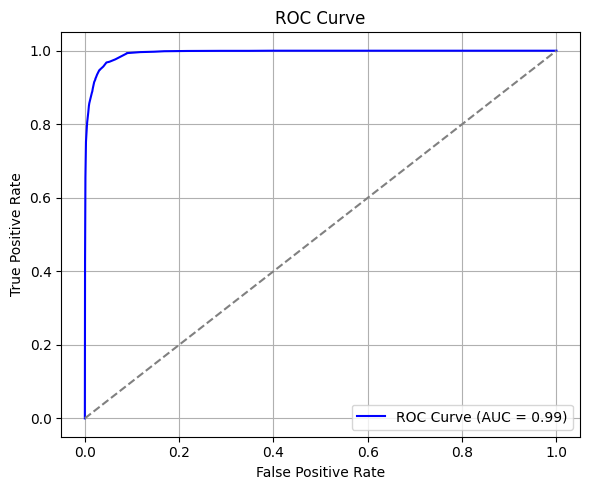

['xgboost_model.pkl']

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    roc_curve
)
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib  # עבור שמירת המודל

# קריאת הנתונים
df_all = pd.read_csv('utils/combined_wafer_features.csv')
df_all['IsScratchDie'] = df_all['IsScratchDie'].astype(bool)
df_all['IsGoodDie'] = df_all['IsGoodDie'].astype(bool)

# סינון שורות תקפות
df_all = df_all[df_all['IsScratchDie'].isin([True, False])].copy()

# הגדרת קלט ופלט — רק הפיצ'רים הרלוונטיים שנשארו
feature_columns = [
    'BadNeighbors_ofGood',
    'BadNeighbors_ofBad',
    'SecondLayerBadNeighbors_ofGood',
    'SecondLayerBadNeighbors_ofBad',
    'DistanceToBadCluster'
]

target_column = 'IsScratchDie'

# חלוקה לסטים
X = df_all[feature_columns]
y = df_all[target_column]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# יצירת המודל XGBoost
model = xgb.XGBClassifier(
    random_state=42, 
    scale_pos_weight=15,  # Adjusting for class imbalance
    eval_metric='logloss', 
    use_label_encoder=False
)

# אימון המודל
model.fit(X_train, y_train)

# חיזוי
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]  # הסתברות ל־True

# מדדים
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_probs)

# הדפסה של תוצאות
print(f"\nAccuracy: {accuracy:.4f}")
print(f"Precision (True class): {precision:.4f}")
print(f"Recall (True class): {recall:.4f}")
print(f"F1-score (True class): {f1:.4f}")
print(f"ROC AUC: {auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# גרף ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# שמירת המודל לקובץ
joblib.dump(model, 'xgboost_model.pkl')


**Confusion Matrix:**


Confusion Matrix:
[[360779    853]
 [   720   2187]]


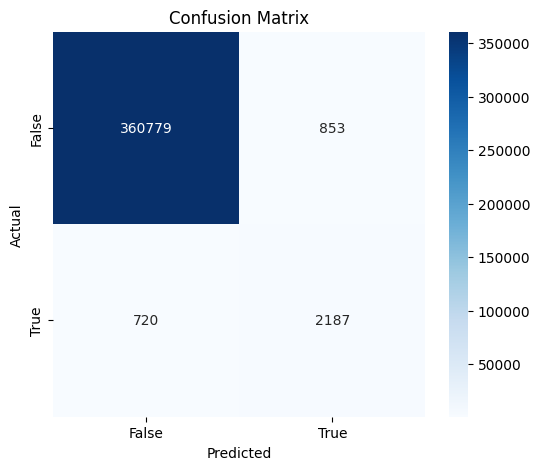

In [96]:
from sklearn.metrics import confusion_matrix

# חישוב מטריצת בלבול
cm = confusion_matrix(y_test, y_pred)

# הדפסת מטריצת הבלבול
print("Confusion Matrix:")
print(cm)

# אפשר גם להציג את מטריצת הבלבול בגרף חם (Heatmap)
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


**Feature Importance:**

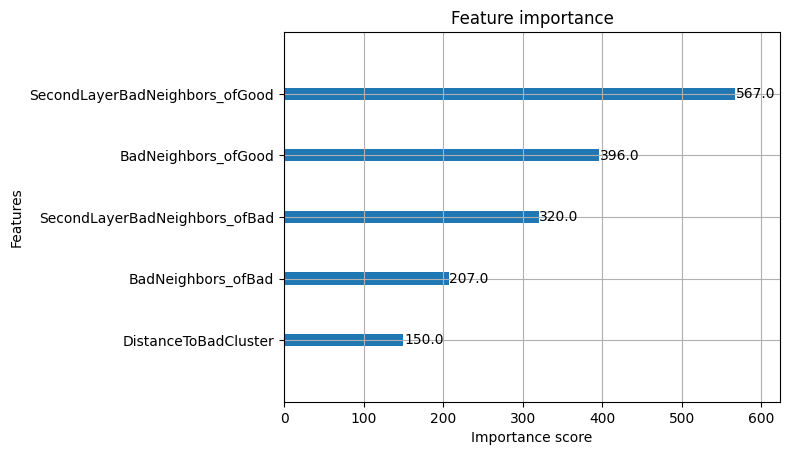

{'BadNeighbors_ofGood': 396.0, 'BadNeighbors_ofBad': 207.0, 'SecondLayerBadNeighbors_ofGood': 567.0, 'SecondLayerBadNeighbors_ofBad': 320.0, 'DistanceToBadCluster': 150.0}


In [85]:
import xgboost as xgb
import matplotlib.pyplot as plt

# הצגת חשיבות הפיצ'רים
fi = xgb.plot_importance(model)
plt.show()

# הדפסת חשיבות הפיצ'רים
print(model.get_booster().get_fscore())



**המרת קובץ סט המבחן למבנה נתונים אפשר למחוק??**

In [63]:
import pandas as pd
import random

# קריאת הנתונים מתוך הקובץ
df_wafers_test = pd.read_csv('data/wafers_test.csv')

# חישוב גודל כל WaferName (כמה רשומות יש לו)
wafer_counts = df_wafers_test['WaferName'].value_counts()

# יצירת DataFrame עם WaferName ו-Size
df_counts = wafer_counts.reset_index()
df_counts.columns = ['WaferName', 'Size']

# קיבוץ לפי גודל ובחירה אקראית של 5 וופרים מכל גודל
sampled_wafers_test = df_counts.groupby('Size').apply(
    lambda group: group.sample(n=min(5, len(group)), random_state=42)
).reset_index(drop=True)

# הדפסת התוצאה
print(sampled_wafers_test)


   WaferName  Size
0     GVyPQT  1005
1     oRJKPT  1005
2     GVNu8k  1005
3     GquiGD  1005
4     rR2rkC  1005
5     ELLNkq  1513
6     yrDGVN  1513
7     eLkOL2  1513
8     azjzu4  1513
9     jWHz8M  1513
10    KOy0C2  1941
11    1EhccD  1941
12    bpeRIl  1941
13    EG5bjs  1941
14    rdeamR  1941
15    mfS8Nd  2449
16    kNJdZM  2449
17    WpfSfc  2449
18    jrfIGo  2449
19    1KrD6F  2449
20    JdaJx2  2997
21    zEDmz5  2997
22    KPQQVA  2997
23    iTR87i  2997
24    J2NIx9  2997
25    sZGPOb  3405
26    vroqLL  3405
27    90hIaz  3405
28    Ery20w  3405
29    TfM7eN  3405
30    PhZyEQ  4049
31    G2K56s  4049
32    n2iH0U  4049
33    DqGjEm  4049
34    Ad6y7N  4049


C:\Users\olegl\AppData\Local\Temp\ipykernel_23608\3601808484.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_wafers_test = df_counts.groupby('Size').apply(


**Feature extraction for the test set.**

In [25]:
import pandas as pd

# קריאת הנתונים מתוך הקובץ wafers_test
df_wafers_test = pd.read_csv('data/wafers_test.csv')

# יצירת רשימה של DataFrame — אחד לכל WaferName
wafer_names = df_wafers_test['WaferName'].unique()
all_wafers_list = [
    df_wafers_test[df_wafers_test['WaferName'] == name]
    for name in wafer_names
]

# הפעלת הפונקציה create_features על כל הוופרים
list_all_test_features = create_features(all_wafers_list)

# מיזוג התוצאות ל-DataFrame אחד
df_test_features = pd.concat(list_all_test_features)

# יצירת קובץ CSV עם הפיצ'רים בלבד
output_df = df_test_features[['WaferName', 'DieX', 'DieY', 'IsGoodDie', 
    'BadNeighbors_ofGood', 
    'BadNeighbors_ofBad',
    'SecondLayerBadNeighbors_ofGood',
    'SecondLayerBadNeighbors_ofBad',
    'DistanceToBadCluster']]

# שמירת הקובץ
output_df.to_csv('utils/wafers_with_features_test.csv', index=False)

print("הפלט נשמר בקובץ 'utils/wafers_with_features_test.csv'.")



Processing wafer 1/455
Calculating BadNeighbors...
Calculating SecondLayerBadNeighbors...
Calculating DistanceToBadCluster...
Finished processing wafer 1.


Processing wafer 2/455
Calculating BadNeighbors...
Calculating SecondLayerBadNeighbors...
Calculating DistanceToBadCluster...
Finished processing wafer 2.


Processing wafer 3/455
Calculating BadNeighbors...
Calculating SecondLayerBadNeighbors...
Calculating DistanceToBadCluster...
Finished processing wafer 3.


Processing wafer 4/455
Calculating BadNeighbors...
Calculating SecondLayerBadNeighbors...
Calculating DistanceToBadCluster...
Finished processing wafer 4.


Processing wafer 5/455
Calculating BadNeighbors...
Calculating SecondLayerBadNeighbors...
Calculating DistanceToBadCluster...
Finished processing wafer 5.


Processing wafer 6/455
Calculating BadNeighbors...
Calculating SecondLayerBadNeighbors...
Calculating DistanceToBadCluster...
Finished processing wafer 6.


Processing wafer 7/455
Calculating BadNeighbors...
Calcul

**Making predictions on the test set.**

In [ ]:
import pandas as pd
import joblib  # אם המודל נשמר כקובץ joblib
import random  # אם יש צורך בהוספת ערכים אקראיים (למשל לדוגמא)

# קריאת הקובץ wafers_with_features_test.csv
df = pd.read_csv('utils/wafers_with_features_test.csv')

# הוספת עמודת IsScratchDie עם ערכים אקראיים (אפשר לשנות לפי הצורך)
# בהנחה שהמודל שלך לא מכיל את עמודת המטרה בקובץ
df['IsScratchDie'] = [random.choice([True, False]) for _ in range(len(df))]

# הגדרת העמודות לפיצ'רים
feature_columns = [
    'BadNeighbors_ofGood', 
    'BadNeighbors_ofBad',
    'SecondLayerBadNeighbors_ofGood',
    'SecondLayerBadNeighbors_ofBad',
    'DistanceToBadCluster'
]

# קריאת המודל שלך (אם הוא נשמר כקובץ joblib)
# למשל, אם המודל נשמר כקובץ בשם model.pkl:
model = joblib.load('xgboost_model.pkl')

# חיזוי על פי המודל
X_test = df[feature_columns]
df['IsScratchDie'] = model.predict(X_test)

# המרת תוצאה ל־Boolean במקום 0/1
df['IsScratchDie'] = df['IsScratchDie'].astype(bool)

# שמירת הפלט בקובץ CSV חדש
df.to_csv('utils/predictions_results.csv', index=False)

print("החיזוי הושלם והפלט נשמר בקובץ 'wafers_with_predictions_test.csv'.")


החיזוי הושלם והפלט נשמר בקובץ 'wafers_with_predictions_test.csv'.


**Visualization of the prediction results.**

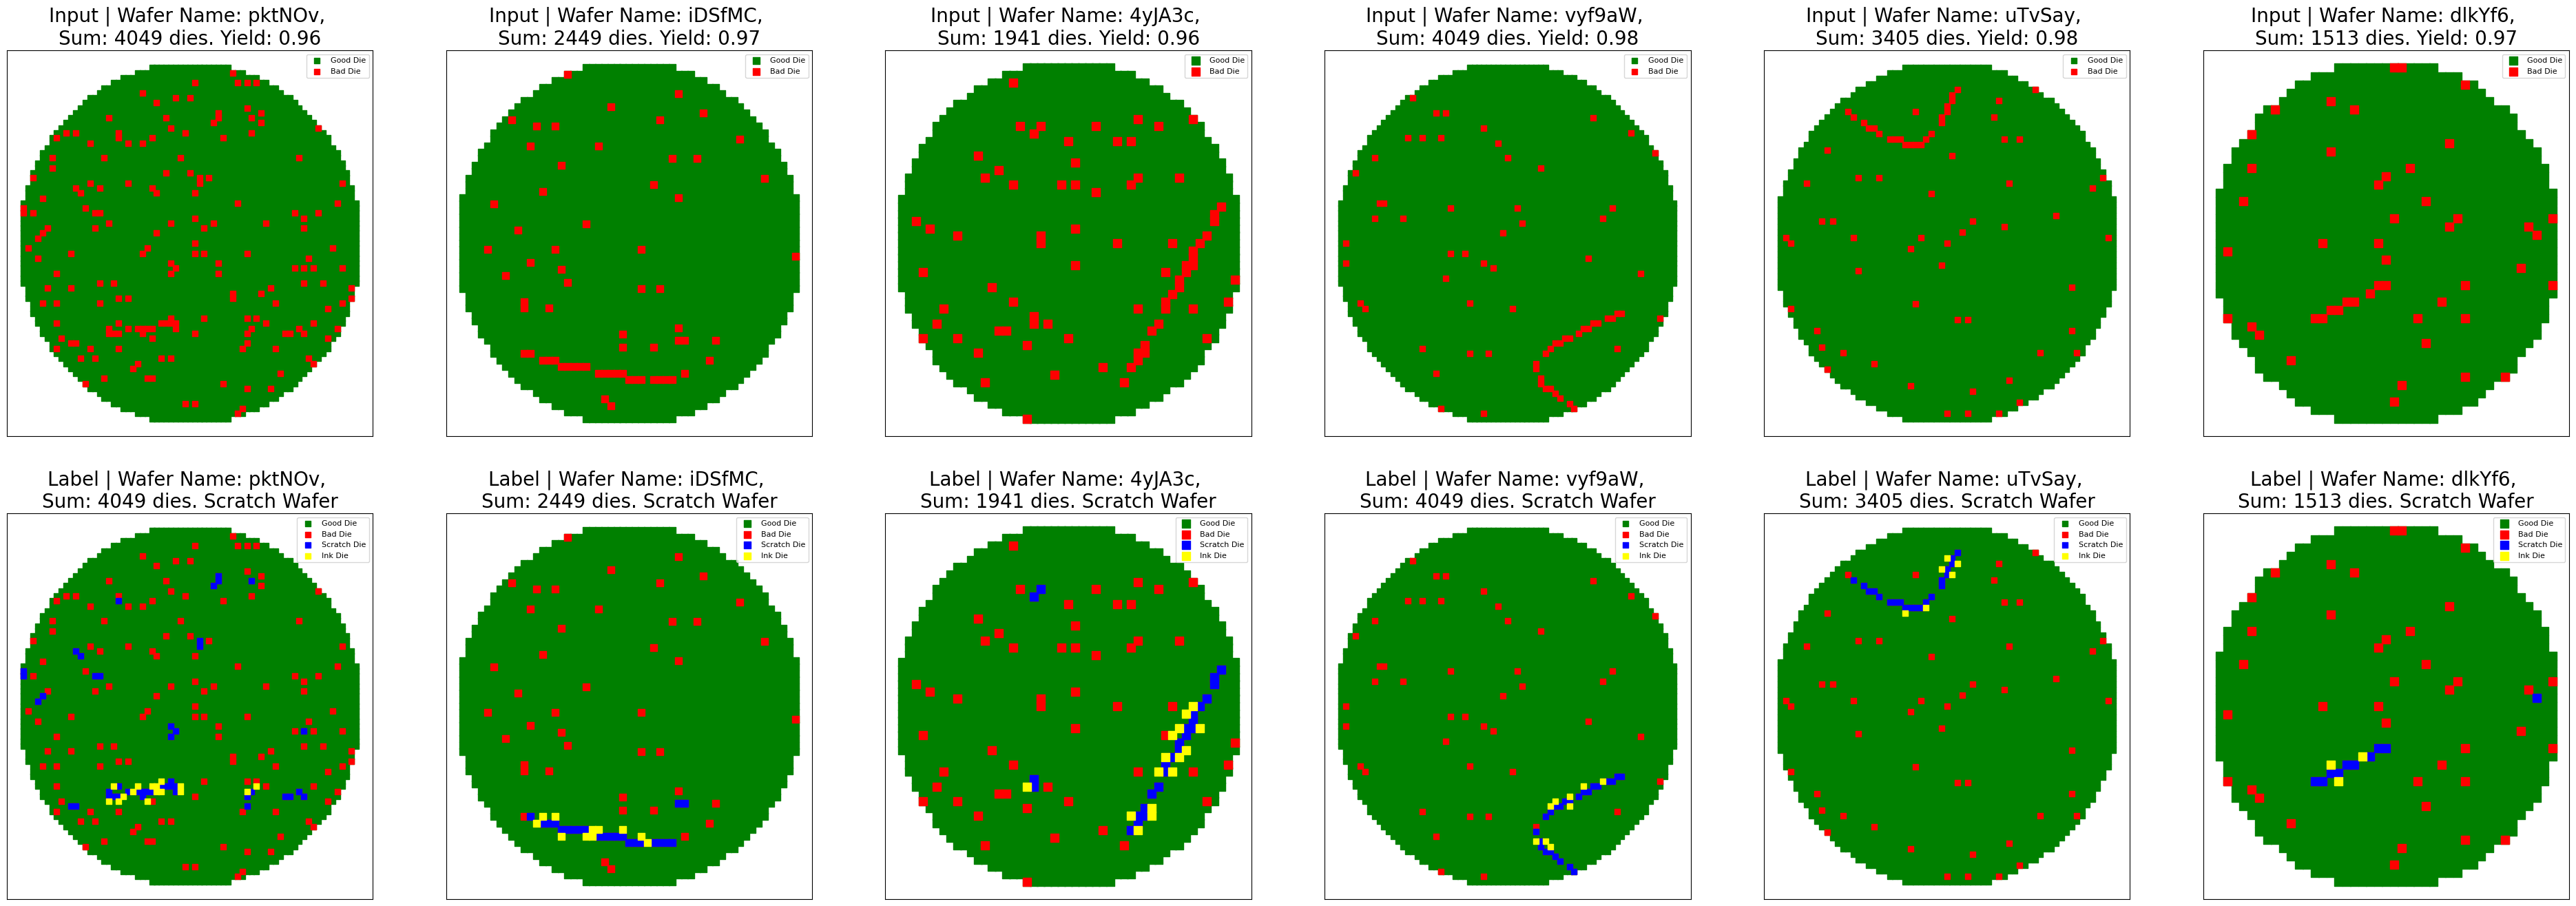

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import random

# קריאת הקובץ wafers_with_predictions_test.csv
df = pd.read_csv('utils/predictions_results.csv')



def plot_wafer_maps(wafer_df_list, figsize, labels=True):
    """
    Plot wafer maps for list of df of wafers

    :param wafer_df_list: list, The list of df's of the wafers
    :param figsize: int, the size of the figsize height
    :param labels: bool, Whether to show the layer of labels (based on column 'IsScratchDie')
    
    :return: None
    """
    def plot_wafer_map(wafer_df, ax, map_type):
        wafer_size = len(wafer_df)
        s = 2**17 / wafer_size
        if map_type == 'Label':
            mes = 'Scratch Wafer' if (wafer_df['IsScratchDie'] == True).sum() > 0 else 'Non-Scratch Wafer'
        else:
            mes = 'Yield: ' + str(round((wafer_df['IsGoodDie']).sum() / (wafer_df['IsGoodDie']).count(), 2))

        ax.set_title(f'{map_type} | Wafer Name: {wafer_df["WaferName"].iloc[0]}, \nSum: {len(wafer_df)} dies. {mes}', fontsize=20)
        ax.scatter(wafer_df['DieX'], wafer_df['DieY'], color='green', marker='s', s=s)

        bad_bins = wafer_df.loc[wafer_df['IsGoodDie'] == False]
        ax.scatter(bad_bins['DieX'], bad_bins['DieY'], color='red', marker='s', s=s)

        if map_type == 'Label':
            scratch_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == False)]
            ax.scatter(scratch_bins['DieX'], scratch_bins['DieY'], color='blue', marker='s', s=s)

            ink_bins = wafer_df.loc[(wafer_df['IsScratchDie'] == True) & (wafer_df['IsGoodDie'] == True)]
            ax.scatter(ink_bins['DieX'], ink_bins['DieY'], color='yellow', marker='s', s=s)

            ax.legend(['Good Die', 'Bad Die', 'Scratch Die', 'Ink Die'], fontsize=8)
        else:
            ax.legend(['Good Die', 'Bad Die'], fontsize=8)

        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False) 

    import numpy as np
    
    if labels:
        fig, ax = plt.subplots(2, len(wafer_df_list), figsize=(figsize * len(wafer_df_list), figsize * 2))
        for idx1, wafer_df in enumerate(wafer_df_list):
            for idx2, map_type in enumerate(['Input', 'Label']):
                plot_wafer_map(wafer_df, ax[idx2][idx1], map_type)
    else:
        fig, ax = plt.subplots(1, len(wafer_df_list), figsize=(figsize * len(wafer_df_list), figsize))
        for idx, wafer_df in enumerate(wafer_df_list):
            plot_wafer_map(wafer_df, ax[idx], 'Input')

    plt.show()

# חלוקה לפי שמות וופרים
n_samples = 6  # מספר הדוגמאות להציג
list_sample_train = [df.groupby('WaferName').get_group(group) for group in df['WaferName'].value_counts().sample(n_samples, random_state=20).index]

# יצירת המפות עבור הדוגמאות
plot_wafer_maps(list_sample_train, figsize=8, labels=True)


In [ ]:
import pandas as pd

# קריאת הקובץ
df = pd.read_csv('utils/predictions_results.csv')


# חישוב טבלת סיכום לכל דיסק (Wafer)
summary = (
    df.groupby('WaferName')
    .agg(
        TotalDies=('IsScratchDie', 'count'),
        ScratchCount=('IsScratchDie', lambda x: (x == True).sum())
    )
    .reset_index()
)

# עמודת אינדיקציה אם יש שריטות בכלל
summary['HasScratch'] = summary['ScratchCount'] > 0

# חישוב אחוז גודל השריטה
summary['ScratchPercent'] = (summary['ScratchCount'] / summary['TotalDies']) * 100

# בחירת העמודות להצגה
result = summary[['WaferName', 'HasScratch', 'ScratchPercent']]

# הצגת הטבלה
print(result)


  WaferName  HasScratch  ScratchPercent
0    ELLNkq        True        3.899537
1    GVyPQT        True        0.796020
2    JdaJx2        True        1.067734
3    KOy0C2        True        3.967027
4    PhZyEQ        True        1.951099
5    mfS8Nd        True        2.000817


# Additional thoughts

Here you can detail about anything you want to mention as additional considerations for this solution, anything from ideas, thoughts, considerations about deployment or anything you may have raised when working on this task in a team.

In [ ]:
#I’m currently taking a course on parallel and distributed programming, and I originally planned to implement this feature extraction step using multiprocessing to speed things up. Unfortunately, I didn’t get to finish that optimization in time — but the idea (and partial code!) is ready to go.


# Submission

In [ ]:
#TODO

model = xgboost_model.pkl
IsScratchDie = model.predict(df_wafers_test)
df_wafers_test['IsScratchDie'] = IsScratchDie

#TODO Fill in your name and email
name = 'Oleg Lafer'
email = 'oleg.lafer@gmail.com'

#Dont change the following code
date_str = datetime.now().strftime('%Y%m%d')
filename = f"{date_str}_{name}_{email}_df_wafers_test_with_preds.csv"
df_wafers_test.to_csv(filename, index=False)
print("Saved file:", filename)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- IsGoodDie
- WaferName
Feature names seen at fit time, yet now missing:
- BadNeighbors
- DensityBadNeighbors
- DistanceToBadCluster
- IsScratchDie
- SecondLayerBadNeighbors
